In [1]:
import spacy
import json


In [2]:
def load_data(file):
    with open(file,"r",encoding="utf-8") as f:
        data = json.load(f)
    return data

def write_data(file,data):
    with open(file,"w",encoding="utf-8") as f:
        json.dump(data,f,indext=4)

In [3]:
# nlp = spacy.load("models/model-best/")
nlp = spacy.load("final_models_v2//model-best/")

In [4]:
docs = load_data("data/pl_test_data.json")
docs[0]

['Description  Job Description Analyse data to understand customers’ behaviours and interest Translate data insights into useful content to drive customers’ engagement Identify trends on the profitability of products and services and highlight opportunities or concerns Research into trade related content provided by other brokers or investment related platform and conduct cost-benefit analysis Gather statistics on other brokers/investment platform and generate ideas to give OSPL competitive edge Job Qualifications  Qualifications Bachelor or diploma in Computer Science, Information Systems or related fields. Experience with trading and investment preferred but not mandatory Comfortable with handling large set of data on excel Proficient in Excel and keen on data story telling Attention to detail as data analysis and reporting must be precise Good presentation, articulation and listening skills. Scripting language is a plus Primary Location  Singapore  Job  Internship  Organization  Gro

In [5]:
from spacy.training import offsets_to_biluo_tags
def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        # print (doc)
        new = nlp.make_doc(doc[0])
        entities = doc[1]["entities"]
        bilou_entities = offsets_to_biluo_tags(new, entities)
        final = []
        for item in bilou_entities:
            final.append(get_cleaned_label(item))
        target_vector.extend(final)
    return target_vector



In [6]:
def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = nlp(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

In [7]:
def get_model_labels():
    labels = list(nlp.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)
def get_dataset_labels():
    return sorted(set(create_total_target_vector(docs)))

In [8]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)
    y_pred = create_total_prediction_vector(docs)
    # print (y_true)
    # print (y_pred)
    return confusion_matrix(y_true, y_pred, labels=classes)

In [9]:
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(docs, classes, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = 'Confusion Matrix, for SpaCy NER'

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot

(array([[   23,     0,     0,     0,     0],
        [    0,     5,     5,     0,     2],
        [    0,     0, 17945,    13,     6],
        [    0,     0,    12,    90,     2],
        [    0,     0,     2,     3,    41]], dtype=int64),
 <AxesSubplot:title={'center':'Confusion Matrix, for SpaCy NER'}, xlabel='Predicted label', ylabel='True label'>,
 <module 'matplotlib.pyplot' from 'C:\\Users\\ZACK LEE\\Documents\\Coding\\skill_finder\\env1\\lib\\site-packages\\matplotlib\\pyplot.py'>)

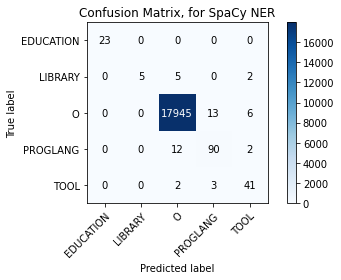

In [10]:
plot_confusion_matrix(docs,classes=get_dataset_labels(),normalize=False)